In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
knitr::opts_chunk$set(echo = TRUE)

nInd<-175
indIDs <-paste0("X", sample(10000:40000, nInd))
nVisits<-rpois(indIDs, 4)
nVisits[which(nVisits == 0)]<-1

cogAbaseline<-rpois(indIDs, 25)
cogBbaseline<-rnorm(indIDs, 8,4)
cogCbaseline<-rnorm(indIDs, 20, 2)
sex<-sample(c("M", "F"), nInd, replace = TRUE, prob = c(0.55, 0.45))
age<-floor(runif(nInd, 20, 60))
intervention<-sample(c("Placebo", "Training"), nInd, replace = TRUE)
yearsEd<-sample(c(12,14,17), nInd, replace = TRUE, prob = c(0.3,0.4, 0.3))
smoke <- sample(c("Yes", "No"), nInd, replace = TRUE, prob = c(0.25,0.75))
physicalWellbeing <- sample(c("High", "Low"), nInd, replace = TRUE, prob = c(0.85,0.15))
mentalWellbeing <- sample(c("High", "Low"), nInd, replace = TRUE, prob = c(0.7,0.3))
cogAbaseline <- cogAbaseline[(physicalWellbeing == "Low" | mentalWellbeing == "Low")]<- rpois(sum((physicalWellbeing == "Low" | mentalWellbeing == "Low")), 22)
cogAbaseline <- cogAbaseline[smoke == "Yes"]<- rpois(sum(smoke == "Yes"), 23)

visitID<-as.factor(rep(indIDs, nVisits))
visitNum <- unlist(lapply(nVisits, seq))

index<-match(visitID, indIDs)
visitSex<-as.factor(sex[index])
visitAge<-age[index]+visitNum
visitIntervention<-as.factor(intervention[index])
visitYearsEd <- yearsEd[index]
visitSmoke <- as.factor(smoke[index])
visitPW <- as.factor(physicalWellbeing[index])
randomIndex<-sample(1:length(index), nInd)
visitPW[randomIndex]<-"Low"
visitMW <-as.factor(mentalWellbeing[index])
randomIndex<-sample(which(visitNum > 3), nInd*0.5)
visitMW[randomIndex]<-"High"
    
cogA<- floor(cogAbaseline[index] + visitNum * (0.2 + 0.05 * as.numeric(visitIntervention) + 0.04 * as.numeric(visitMW)) + rnorm(length(visitNum), 0,2))

cogB<-cogBbaseline[index] + visitNum * (0.1 - 0.08 * as.numeric(visitSex) + 0.05 * (visitYearsEd-12)) + rnorm(length(visitNum), 0, 1) 

cogC<-cogCbaseline[index] + visitNum * (0.01 + 0.003 * as.numeric(visitSex) + 0.001 * as.numeric(visitIntervention)) + rnorm(length(visitNum), 0, 5) 


cogDat<-data.frame("ID" = visitID, "VisitNum" = visitNum, "Age" = visitAge, "Sex" = visitSex, "YearsEducation" = visitYearsEd, "Smoker" = visitSmoke, "Intervention" = visitIntervention, "CognitionA" = cogA, "CognitionB" = cogB, "CognitionC" = cogC, "PhysicalWellbeing" = visitPW, "MentalWellbeing" = visitMW)


# Regression models with interaction terms

Regression allows us to explore complex relationships between more than two variables. Next, we are going to look at how to model these. Let's assume we have two variables, height and weight, and we are interesting in how their relationship is affected by sex. We could split our data in two subsets, one for males and one for females and fit two separate regression models. With those results we could then compare the estimated parameters. It can be really tempting to compare if coefficients for height on weight are both significant or not. This can be a trap though, as significance is influenced not just by whether there is an effect but also the variation in the sample, the size of the effect and the size of the data set. If you have different numbers of males and females, it could just be that you have power to detect an effect in one sex and not the other. So it's very easy to come to an incorrect conclusion from this approach. Instead you could compare the estimated regression parameters, but they will inevitably be different due to sampling variation, even if they should be the same. So how do you decide if they are different enough to be interesting? Ideally we want to do a statistical test to quantify is there is evidence of a difference. To do that we need to include both groups in the same regression model.

Interaction terms in regression models allow us to explore whether the relationship between two predictor variables depends on the value of a third variable. They are particularly useful when we suspect that the effect of one predictor on the outcome variable might vary depending on the level of another predictor.

When we include co-variates in regression models we assume they have a (fixed) additive effect that represents the effect of all the samples in our data set.

Let's explore this for our height and weight example with the following regression model:

$$weight = \beta_{0} + \beta_{1} height + \beta_{2} sex$$ where for females, sex = 0 and for males, sex = 1.

If we want to make predictions for females (i.e. when sex = 0), the equation becomes:

$$weight = \beta_{0} + \beta_{1} height + \beta_{2} 0 = \beta_{0} + \beta_{1} height$$

The relationship between height and weight is captured by $\beta_{1}$

If we want to make predictions for males (i.e. when sex = 1), the equation becomes:

$$weight = \beta_{0} + \beta_{1} height + \beta_{2} 1 = \beta_{0} + \beta_{1} height  + \beta_{2}$$ 

While the intercept differs, the relationship between height and weight is only captured by $\beta_{1}$. If we want to allow for sex specific effects, we need the slope to be captured by parameters that depend on sex. This what an interaction term does - by multiplying two or more predictor variables together to investigate whether their joint effect on the outcome is different from what would be expected if their effects were independent of each other. Of course with an extra term in the model we have an extra parameter.

$$weight = \beta_{0} + \beta_{1} height + \beta_{2} sex + \beta_{3} height * sex$$

If we repeat what we did before and deduce the formula for the predictions for a female and male, we can see how this works.

To predict weight for a female (i.e. $sex = 0$) 

$$weight = \beta_{0} + \beta_{1} height + \beta_{2} 0 + \beta_{3} height * 0 = \beta_{0} + \beta_{1} height$$

To predict weight for a male (i.e. $sex = 1$) 

$$weight = \beta_{0} + \beta_{1} height + \beta_{2} 1 + \beta_{3} height * 1 \\ = \beta_{0} + \beta_{1} height  + \beta_{2} + \beta_{3} height = (\beta_{0} + \beta_{2}) + (\beta_{1} + \beta_{3})height$$ 

We can see the differences more closely in the table below:

|  Sex   |        Intercept        |    Slope coefficient    |
|:------:|:-----------------------:|:-----------------------:|
| female |       $\beta_{0}$       |       $\beta_{1}$       |
|  male  | $\beta_{0} + \beta_{2}$ | $\beta_{1} + \beta_{3}$ |

We still have the sex specific intercepts, but this time we additionally have a sex specific slope parameter for height, with $\beta_{3}$ capturing the additional effect.

## Fitting interaction models in R

We are going to look at how to code an interaction term in R by extending the mixed effects models we fitted earlier. Earlier we fitted a model to see whether cognition changed over the course of the study. Next we will test to see if this effect is consistent between females and males. To quantify that we will add an interaction term between `VisitNum` and `Sex`.


In [3]:
%%R
library(lme4)
model.int<-lmer(CognitionB ~ VisitNum + Sex + VisitNum*Sex + (1|ID), dat = cogDat)
summary(model.int)

Linear mixed model fit by REML ['lmerMod']


Formula:

CognitionB ~ VisitNum + Sex + VisitNum * Sex + (1 | ID)

   Data:

cogDat

REML criterion at convergence:

2714.5

Scaled residuals:

    Min 

     1Q 

 Median 

     3Q 

    Max 

-3.4769 

-0.5681 

-0.0122 

 0.5798 

 3.6596 

Random effects:


 Groups  

 Name       

 Variance

 Std.Dev.

 ID      

 (Intercept)

 17.000  

 4.123   

 Residual

  1.014  

 1.007   

Number of obs: 699, groups: 

ID, 175


Fixed effects:


 Estimate

 Std. Error

 t value


(Intercept)  

  8.04396

    0.47955

  16.774


VisitNum     

  0.13622

    0.04188

   3.253


SexM         

  0.08885

    0.64604

   0.138


VisitNum:SexM

 -0.06687

    0.05278

  -1.267


Correlation of Fixed Effects:


 (Intr)

 VistNm

 SexM  


VisitNum   

 -0.213


SexM       

 -0.742

  0.158


VisitNm:SxM

  0.169

 -0.793

 -0.203

Loading required package: Matrix


From the output above we can see that we have four regression coefficients (one per row) for our fixed effects. If we apply a p-value threshold of 0.05, we would conclude that `VisitNum` has a significant effect on cognitive performance, but sex does not. The bottom row contains the result for the interaction, and as with the main effect for sex, we can see that R has appended the name of the contrast category to the name of the interaction. We can see that the interaction is significant with a P-value of `r signif(coef(summary(model.int))["VisitNum:SexM", "Pr(>|t|)"],3)`. The estimated regression coefficient is `r signif(coef(summary(model.int))["VisitNum:SexM", "Estimate"],3)` which represents the change in the VisitNum slope parameter for males relative to females.

## Graphical representation of an interaction effect

Let's look at a visualisation of these two sex specific regression models, where we will plot two lines one for females and one for males.


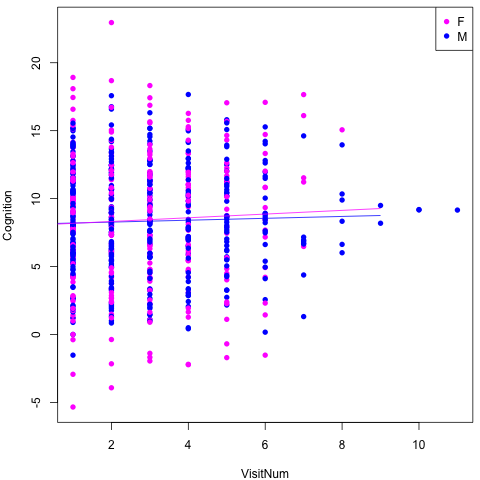

In [4]:
%%R

fixed.means<-coef(summary(model.int))[,"Estimate"]

x.sample<-c(0:9)
# mean female effect
y.female <- fixed.means[1] + x.sample * fixed.means[2]

# mean male effect
y.male <- fixed.means[1] + fixed.means[3] + x.sample * (fixed.means[2] + fixed.means[4])

par(mar = c(4,4,0.5,0.5))
plot(cogDat$VisitNum, cogDat$CognitionB, pch = 16, col = c("magenta", "blue")[cogDat$Sex], xlab = "VisitNum", ylab = "Cognition")
legend("topright", pch = 16, col = c("magenta", "blue"), levels(cogDat$Sex))
 

lines(x.sample, y.male, col = "blue")
lines(x.sample, y.female, col = "magenta")

We can see in the scatterplot that the male and female mean lines start at approximately the same place on the y-axis. This fits with the sex main effect not being significant and that there is no difference at baseline in cognitive scores. What we can also see is that the mean performance of the course of the study differs. Specifically, females scores improve at a faster rate as the pink line is steeper. While the graph is helpful to visualise this, we can also draw these conclusions by calculating the values of the intercept and slope coefficients for each sex from the regression parameters. These values are included in the table below. 


|  Sex   |                   Intercept                   |                Slope coefficient                |
|:--------------:|:--------------------------:|:--------------------------:|
| female |         `r signif(fixed.means[1],2)`          |          `r signif(fixed.means[2],2)`           |
|  male  | `r signif(fixed.means[1] + fixed.means[3],2)` | `r signif((fixed.means[2] + fixed.means[4]),2)` |

From the table we can see that the effect is males is accuately slightly negative, which was hard to see in the figure. 

### Exercise 4


*Let's practise fitting models with interaction terms*

Write the R code required to test using a mixed effects regression model the following. For each model include a random intercept for individual.

1.  Is the change in cognitive performance across the study influence by the intervention group? Test each cognitive score in turn.


In [5]:
#model.int.coga<-lmer(CognitionA ~ VisitNum + ... + (1|ID), data = cogDat)
#model.int.cogb<-
#model.int.cogc<-

```{admonition} Solution
:class: dropdown
``` R
model.int.coga<-lmer(CognitionA ~ VisitNum + Intervention + VisitNum*Intervention + (1|ID), data = cogDat)
summary(model.int.coga)

model.int.cogb<-lmer(CognitionB ~ VisitNum + Intervention + VisitNum*Intervention + (1|ID), data = cogDat)
summary(model.int.cogb)

model.int.cogc<-lmer(CognitionC ~ VisitNum + Intervention + VisitNum*Intervention + (1|ID), data = cogDat)
summary(model.int.cogc)
```
```

In [6]:
from jupyterquiz import display_quiz
display_quiz("questions/regression_models.json")

<IPython.core.display.Javascript object>

## Some notes on interpretation of interaction effects

While a significant interaction is determined solely by looking at the p-value for teh interaction term, its interpretation depends on the value of the main effect. When we report that there is a difference between two groups, this could manifest in a number of ways. The interaction term has to be flexible enough to detect all of these. Below we plot a few examples. 

Let's consider the model:

$$y = \beta_{0} + \beta_{1} x + \beta_{2} sex + \beta_{3} * x * sex$$

where for females, $sex = 0$ and for males, $sex = 1$

Let's consider a simple example, where there is an effect in only one sex. 


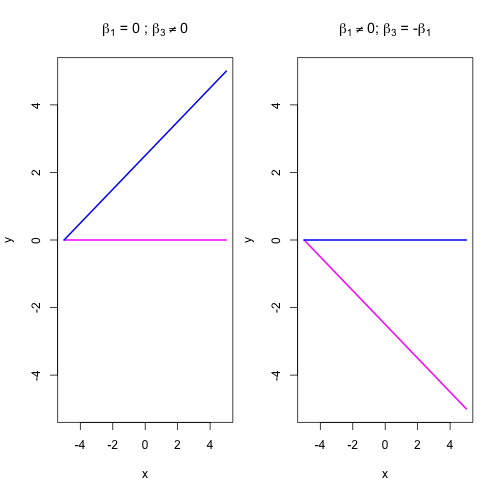

In [7]:
%%R
x.values<-seq(-5,5,0.5)

par(mfrow = c(1,2))
par(mar = c(4,4,4,0.5))

plot(x.values, (x.values * 0 + 0), xlim = c(-5,5), ylim = c(-5,5), col = "magenta", lwd = 2, type = "l", xlab = "x", ylab = "y", main = expression(paste(beta[1], " = 0 ; ", beta[3] != 0)))
lines(x.values, (x.values * 0.5 + 2.5), col = "blue", lwd = 2)

plot(x.values, (x.values * -0.5 - 2.5), xlim = c(-5,5), ylim = c(-5,5), col = "magenta", lwd = 2, type = "l", xlab = "x", ylab = "y", main = expression(paste(beta[1] != 0, "; ", beta[3], " = -", beta[1])))
lines(x.values, (x.values * 0 + 0), col = "blue", lwd = 2)


Above, in the figure on the left, there is no relationship between x and y in females, hence a flat line but there is an effect in males. This would mean that the main effect for x captured by $\beta_{1}$ has to equal to zero and not significant. The significant effect between x and y in males only would be captured by a significantly non-zero, $\beta_{3}$. 


In the figure on the right, there is an effect in females but not males. As the slope coefficient for females is solely determined by $\beta_{1}$ this has to be significantly non-zero. There is a significant difference between the sexes so the interaction coefficient $\beta_3$ is significant. However, for males to have essentially a null effect, $\beta_{3}$ has to be equal and opposite to $\beta_{1}$ so that the combined effect on x equals 0. In this situation the sign of the interaction regression coefficient will be misleading as to the direction of the association for the contrast group.

This might be easier to understand using the table below. For there to be no effect in females $\beta_{1} = 0$, whereas for there to be no effect in males $\beta_{1} + \beta_{3} = 0$. 

|  Sex   |        Intercept        |    Slope coefficient    |
|:------:|:-----------------------:|:-----------------------:|
| female |       $\beta_{0}$       |       $\beta_{1}$       |
|  male  | $\beta_{0} + \beta_{2}$ | $\beta_{1} + \beta_{3}$ |

This however is not the only two possible ways that the groups could differ. It may also be that there is an effect in both sexes but that it is of different orders of magnitude. 


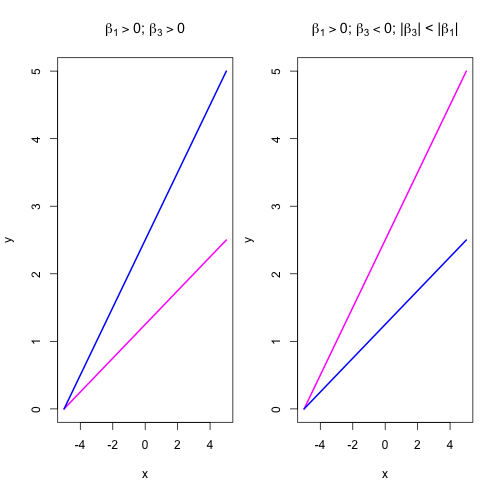

In [8]:
%%R
x.values<-seq(-5,5,0.5)

par(mfrow = c(1,2))
par(mar = c(4,4,4,0.5))

plot(x.values, (x.values * 0.25 + 1.25), xlim = c(-5,5), ylim = c(0,5), col = "magenta", lwd = 2, type = "l", xlab = "x", ylab = "y", main = expression(paste(beta[1] > 0, "; ", beta[3] > 0)))
lines(x.values, (x.values * 0.5 + 2.5), col = "blue", lwd = 2)

plot(x.values, (x.values * 0.5 + 2.5), xlim = c(-5,5), ylim = c(0,5), col = "magenta", lwd = 2, type = "l", xlab = "x", ylab = "y", main = expression(paste(beta[1] > 0, "; ", beta[3] < 0, "; |", beta[3], "| < |", beta[1],"|")))
lines(x.values, (x.values * 0.25 + 1.25), col = "blue", lwd = 2)


The example on the left of the figure above, the relationship is in the same direction, y increases as x increase, but males increase more quickly. Therefore both $\beta_{1}$ and $\beta_{3}$ are significantly non-zero and have the same sign, as $\beta_{1} + \beta_{3} > \beta_{1}$.

If instead, females increased more quickly than males (shown in the right panel above), $\beta{1}$ is positive but  $\beta_{3}$ needs to be negative, but importantly of smaller magnitude than $\beta_{1}$ so that when they are added together the sum is still positive. 


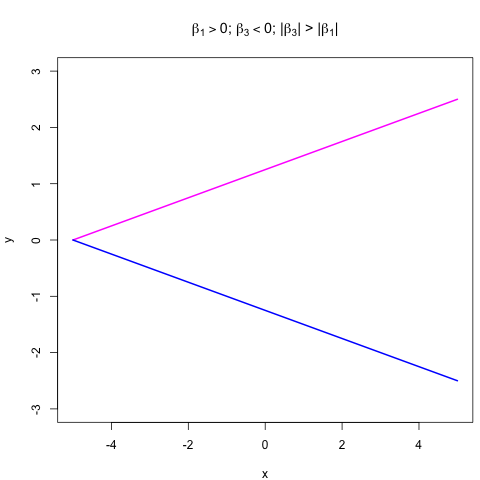

In [9]:
%%R
x.values<-seq(-5,5,0.5)
par(mfrow = c(1,1))
par(mar = c(4,4,4,0.5))

plot(x.values, (x.values * 0.25 + 1.25), xlim = c(-5,5), ylim = c(-3,3), col = "magenta", lwd = 2, type = "l", xlab = "x", ylab = "y", main = expression(paste(beta[1] > 0, "; ", beta[3] < 0, "; |", beta[3], "| > |", beta[1], "|")))
lines(x.values, (x.values * -0.25 - 1.25), col = "blue", lwd = 2)


As a final example we have the most extreme difference, where males and females are both significantly associated, but in opposite directions. $\beta_{1}$ is non-zero to estimate the effect in females, but $\beta_{3}$ is the opposite direction, and of larger magnitude than $\beta_{3}$ so that when they are summed together to give the effect in males, the slope coefficient changes sign. Here the difference between the slope coefficients for males and females is biggest, therefore this behaviour is the one we are most powered to detect. The trickiest situation to detect is subtle differences in magnitude as $\beta_{3}$ is the smallest.

The main take home messgae here is that the value of the regression coefficient tells us nothing unless we also consider the regression coefficient for the main effect. 
